# Importing Essential Libraries

In [ ]:
# d2y/dx2 = wx/EI is to be assumed as differential equation to analyze
# As different experiments have different w/EI, we call it k from now on
# d2y/dx2 = kx; y(0, k) = (dy/dx)(0, k) = 0 for all k, where x = 0 is point of attachment; y(x, 0) = 0 for all x

import tensorflow as tf
import numpy as np
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot as plt

# Defining Neural Network

In [ ]:
# Model takes in the input called state=(x, k=w/EI) and gives y

model_y = Sequential([
    Input(shape=(2,)),
    Dense(20, 'tanh'),
    Dense(40, 'tanh'),
    Dense(60, 'tanh'),
    Dense(40, 'tanh'),
    Dense(20, 'tanh'),
    Dense(1, 'linear', name='Output')
], name='y(x, k)')

model_y.summary()

Model: "y(x, k)"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 40)                840       
                                                                 
 dense_2 (Dense)             (None, 60)                2460      
                                                                 
 dense_3 (Dense)             (None, 40)                2440      
                                                                 
 dense_4 (Dense)             (None, 20)                820       
                                                                 
 Output (Dense)              (None, 1)                 21        
                                                                 
Total params: 6,641
Trainable params: 6,641
Non-trainable p

In [ ]:
model_y.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(2, 20) dtype=float32, numpy=
 array([[-0.20740396, -0.18635705, -0.03522527, -0.50977737, -0.2929273 ,
         -0.4953251 ,  0.14768022, -0.38421568, -0.23594964, -0.22391286,
         -0.20958376,  0.46180326, -0.23236188,  0.20162892,  0.02616155,
          0.16115671,  0.11292809,  0.20364362,  0.20732564,  0.28589535],
        [-0.05773044, -0.48288292, -0.48721835, -0.41502383,  0.01852983,
         -0.01564604, -0.02959254,  0.4173497 , -0.11677024,  0.11849809,
          0.41104275,  0.08811003,  0.13770771, -0.20628649,  0.39819044,
          0.25302422,  0.302365  ,  0.5147169 ,  0.3637604 ,  0.31862408]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(20,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(20, 40) dtype=float32, numpy=
 array([[ 0.18936923, -0.13006589, -0.1938574 ,  0.19973728,  0.283

# Dataset makeup

In [ ]:
x = np.arange(0, 1, 0.01)   # 3m rod will be large enough
k = np.arange(0, 10, 0.1)   # until this point we assume that differential equation hold

grid_x, grid_k = np.meshgrid(x, k)
states = np.array(list(zip(grid_x.reshape(-1), grid_k.reshape(-1))), dtype='float32')

print(states)
print(states.shape)

[[0.   0.  ]
 [0.01 0.  ]
 [0.02 0.  ]
 ...
 [0.97 9.9 ]
 [0.98 9.9 ]
 [0.99 9.9 ]]
(10000, 2)


# Cost Function

In [ ]:
# Cost will be (d2y/dx2 - kx)^2 + y(0, k)^2 + ((dy/dx)(0, k))^2 + y(x, 0)^2

def differential_loss(y_nn, states):
    state_variable = tf.Variable(states)

    with tf.GradientTape() as tape_dubgrad:
        with tf.GradientTape() as tape_grad:
            y = y_nn(state_variable)
        dydx_dydk = tape_grad.gradient(y, state_variable)
    d2ydx2_d2yd2k = tape_dubgrad.gradient(dydx_dydk, state_variable)
    d2ydx2 = d2ydx2_d2yd2k[:, 0]

    diff_loss = (d2ydx2 - states[:, 1] * states[:, 0])**2
    return diff_loss


def boundry_loss(y_nn, states):
    states_x0 = states[states[:, 0] == 0.]
    states_k0 = states[states[:, 1] == 0.]

    bound_loss_x0, bound_loss_k0 = y_nn(states_x0)**2,  y_nn(states_k0)**2

    state_variable_x0 = tf.Variable(states_x0)

    with tf.GradientTape() as tape:
        y = y_nn(state_variable_x0)
    dy_dx_x0 = tape.gradient(y, state_variable_x0)[:, 0]
    bound_loss_x0 += dy_dx_x0**2

    cache = {
        'm_x0': states_x0.shape[0],
        'm_k0': states_k0.shape[0]
    }

    return bound_loss_x0, bound_loss_k0, cache


def compute_cost(y_nn, states, _lambda=0):
    # Loss from differential equation
    m = states.shape[0]
    diff_loss = differential_loss(y_nn, states)
    diff_cost = tf.reduce_sum(diff_loss) / m

    # Loss from boundry conditions
    bound_loss_x0, bound_loss_k0, cache = boundry_loss(y_nn, states)
    bound_cost = tf.reduce_sum(bound_loss_x0) / cache['m_x0'] + tf.reduce_sum(bound_loss_k0) / cache['m_k0']

    frob_reg = 0
    for wts in y_nn.trainable_weights:
        frob_reg += tf.reduce_mean(wts**2)
    frob_reg *= _lambda / 2

    return diff_cost + bound_cost + frob_reg

compute_cost.__doc__ = '''
y_nn: neural network representing deflection for each x given k = w/EI is the situation
states: numpy.ndarray with shape (n, 2) containing the space of states on which to train on
'''

# Test it!
compute_cost(model_y, states)

<tf.Tensor: shape=(), dtype=float32, numpy=19.858433>

# Training

In [ ]:
def train_model(y_nn, num_epochs=300, lr=0.1, decay=0.9, _lambda=0):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, weight_decay=decay)
    cost_history = []

    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            cost_value = compute_cost(model_y, states, _lambda=_lambda)

        gradients = tape.gradient(cost_value, model_y.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model_y.trainable_weights))

        cost_history.append(cost_value)

        print(f'\r[Epoch {epoch + 1}] Loss: {cost_value}', end='')

        if (epoch + 1) % (num_epochs / 10) == 0:
            print(f'\r[Epoch {epoch + 1}] Loss: {cost_value}')

        if cost_value < 1e-10:
            break

    return y_nn, cost_history

train_model.__doc__ = '''
y_nn: neural network representing deflection for each x given k = w/EI is the situation
num_epochs: number of times descent is to be made (default=300)
learning_rate: rate at which descent is made (default=0.1)
'''

In [ ]:
_, cost_history = train_model(model_y, num_epochs=2000, lr=0.003, decay=0.04, _lambda=0.2)
plt.plot(range(len(cost_history)), cost_history)
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Behaviour with epochs')

plt.show()

[Epoch 72] Loss: 10.617574691772461

KeyboardInterrupt: ignored

# Plotting Deformation

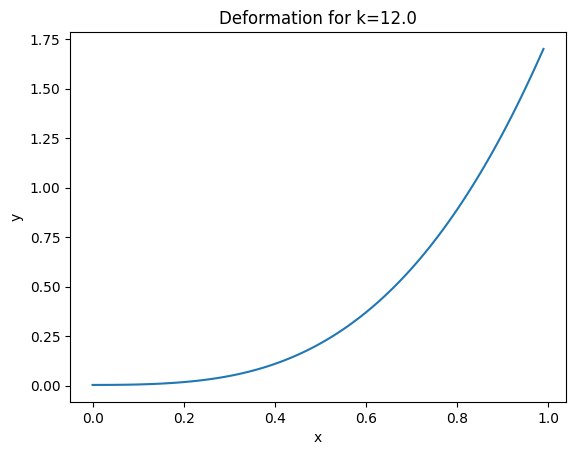

In [ ]:
k_val = 12.
input_x = np.stack((x, k_val * np.ones_like(x)), axis=1)
plt.plot(x, model_y(input_x))
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Deformation for k={k_val}')
plt.show()

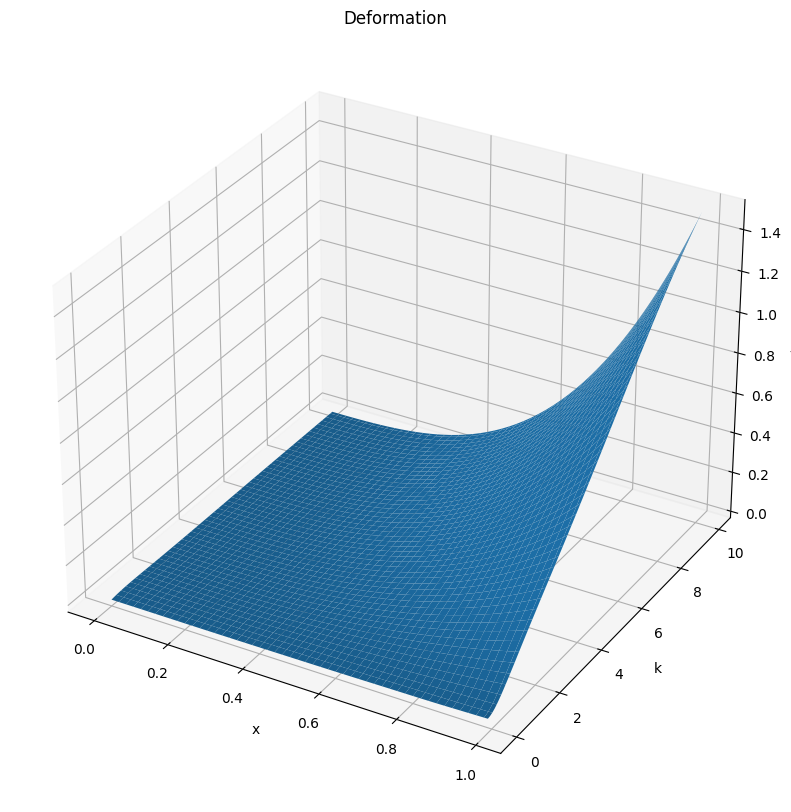

In [ ]:
grid_z = model_y(states).numpy().reshape(*(grid_x.shape))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
ax.plot_surface(grid_x, grid_k, grid_z)
ax.set_xlabel('x')
ax.set_ylabel('k')
ax.set_zlabel('y')
ax.set_title('Deformation')
plt.show()

Text(0.5, 1.0, 'Color map for deformation')

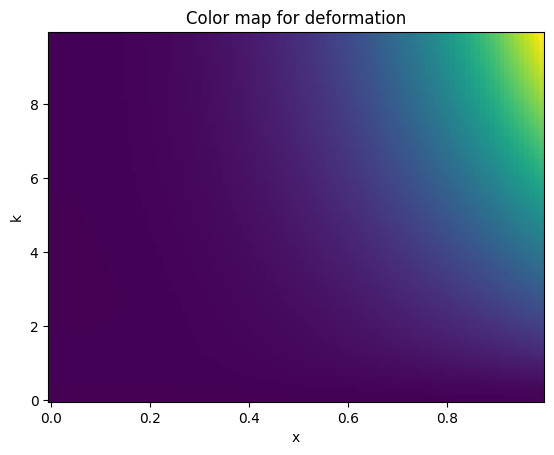

In [ ]:
fig, ax = plt.subplots()
ax.pcolormesh(grid_x, grid_k, grid_z)
ax.set_xlabel('x')
ax.set_ylabel('k')
ax.set_title('Color map for deformation')

# Verification

In [ ]:
# For any k, x the solution comes out to be y = kx^3/6 which satisfies all the boundry conditions

def plot_analysis(model_y, states, grid_x, grid_k):
    actual = states[:, 1] * states[:, 0]**3 / 6
    pred = model_y(states).numpy().reshape(-1)

    accuracy = np.mean((actual - pred)**2)
    print(f'The model\'s accuracy over this dataset is {accuracy*100}')

    fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': '3d'}, figsize=(20, 50))
    prediction = ax[0].plot_surface(grid_x, grid_k, pred.reshape(*(grid_x.shape)), label='Prediction')
    actuality = ax[0].plot_surface(grid_x, grid_k, actual.reshape(*(grid_x.shape)), label='Acutality')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('k')
    ax[0].set_zlabel('y')
    ax[0].set_title('Model prediction vs Actuality')
    prediction._edgecolors2d, prediction._facecolors2d = prediction._edgecolor3d, prediction._facecolor3d
    actuality._edgecolors2d, actuality._facecolors2d = actuality._edgecolor3d, actuality._facecolor3d
    ax[0].legend()

    ax[1].plot_surface(grid_x, grid_k, (pred - actual).reshape(*(grid_x.shape)))
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('k')
    ax[1].set_zlabel('y')
    ax[1].set_title('Offset between prediction and actuality')

    plt.show()

The model's accuracy over this dataset is 0.026452456950210035


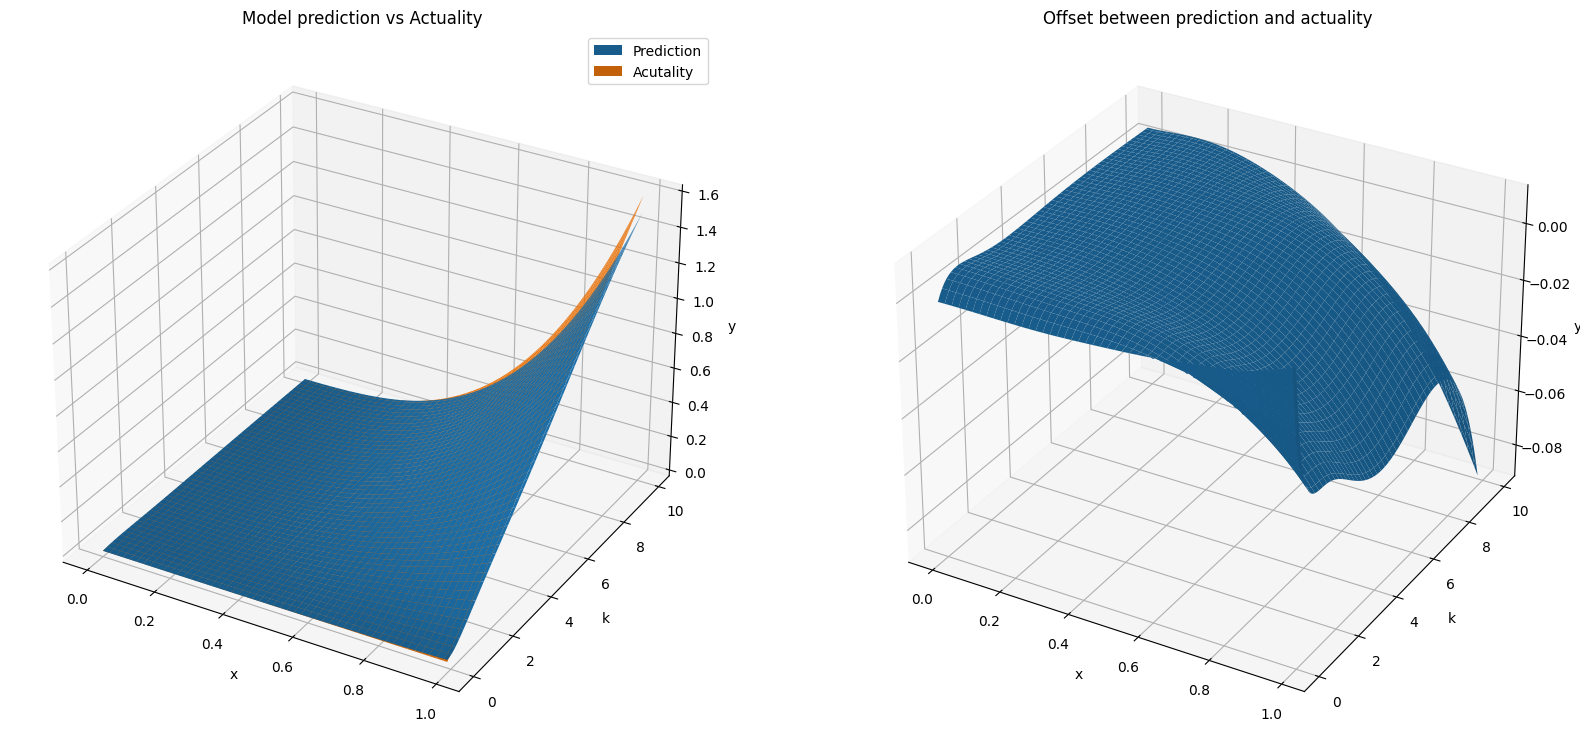

In [ ]:
# Train error
plot_analysis(model_y, states, grid_x, grid_k)

The model's accuracy over this dataset is 2.7488503605127335


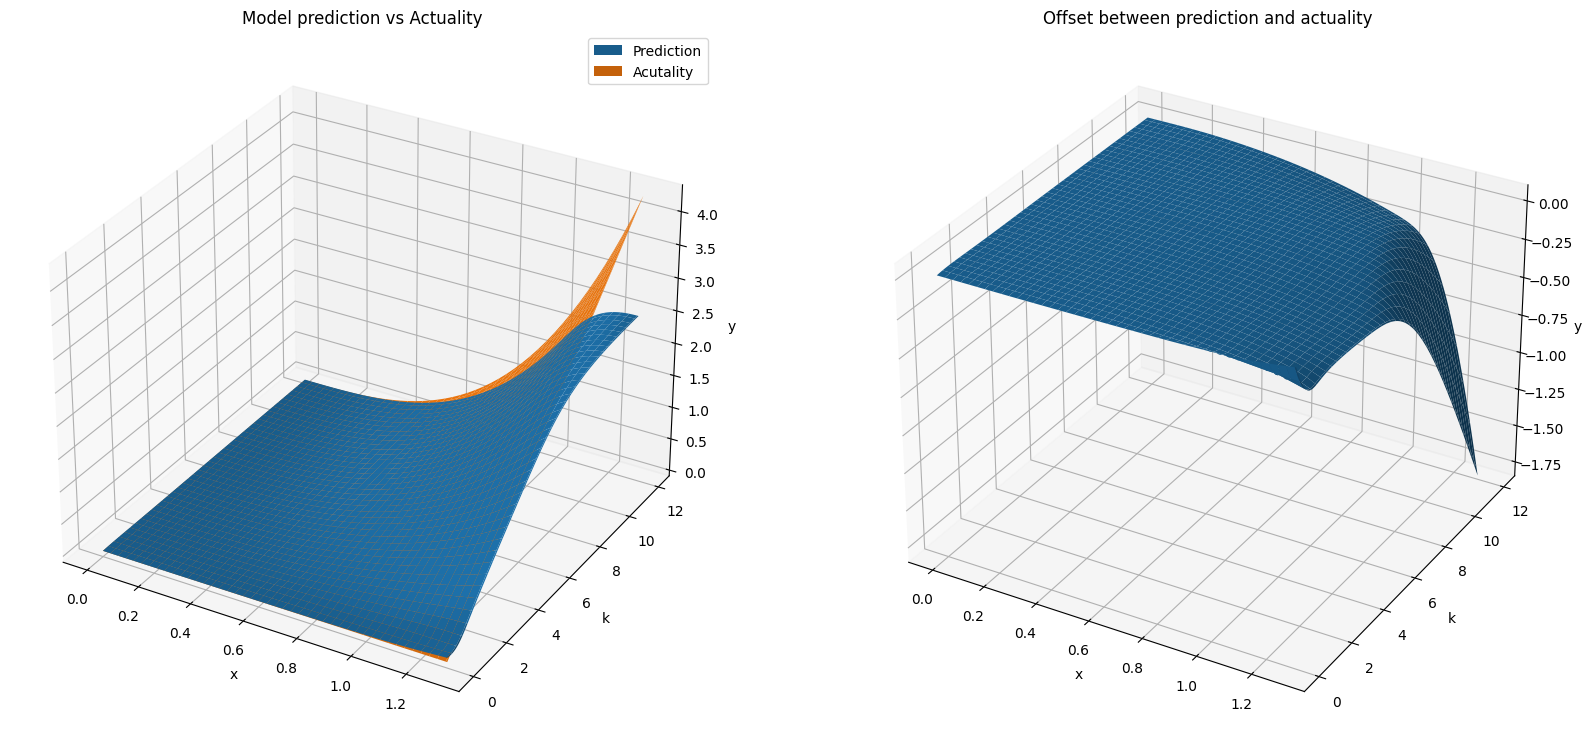

In [ ]:
# Test error
grid_x_test, grid_k_test = np.meshgrid(np.arange(0, 1.3, 0.005), np.arange(0, 12, 0.1))
states_test = np.array(list(zip(grid_x_test.reshape(-1), grid_k_test.reshape(-1))), dtype='float32')
plot_analysis(model_y, states_test, grid_x_test, grid_k_test)